# Home Credit - Feature Engineering Pipeline
## Credit Risk Model Stability

This notebook implements a complete feature engineering pipeline for the Kaggle Home Credit competition:
1. **Aggregate features** from multiple tables
2. **Analyze stability** and remove fluctuating features
3. **Setup StratifiedGroupKFold** with WEEK_NUM as groups
4. **Rank features** by importance

**Date:** February 9, 2026

## 1. Setup & Imports

In [24]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Configuration

In [48]:
# Paths
CSV_DIR = '/Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/csv_files/train'
OUTPUT_DIR = '/Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Feature Engineering Parameters
STABILITY_THRESHOLD = 2.0  # Coefficient of Variation threshold
MAX_NUMERIC_FEATURES = 15  # Per table
MAX_CATEGORICAL_FEATURES = 8  # Per table
N_FOLDS = 5
RANDOM_STATE = 42

print(f"CSV Directory: {CSV_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"\nParameters:")
print(f"  Stability Threshold (CV): {STABILITY_THRESHOLD}")
print(f"  K-Folds: {N_FOLDS}")
print(f"  Random State: {RANDOM_STATE}")

CSV Directory: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/csv_files/train
Output Directory: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output

Parameters:
  Stability Threshold (CV): 2.0
  K-Folds: 5
  Random State: 42


## 3. Load All CSV Files

In [56]:
def load_all_csv_files(directory):
    """Load all CSV files from directory."""
    files = {}
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    for csv_file in sorted(csv_files):
        filepath = os.path.join(directory, csv_file)
        try:
            df = pd.read_csv(filepath)
            files[csv_file.replace('.csv', '')] = df
            print(f"✓ {csv_file}: {df.shape[0]} rows × {df.shape[1]} cols")
        except Exception as e:
            print(f"✗ {csv_file}: {str(e)}")
    
    return files

print(f"Loading {len([f for f in os.listdir(CSV_DIR) if f.endswith('.csv')])} CSV files...\n")
data_files = load_all_csv_files(CSV_DIR)
print(f"\nTotal tables loaded: {len(data_files)}")

Loading 32 CSV files...

✓ train_applprev_1_0.csv: 3887684 rows × 41 cols
✓ train_applprev_1_1.csv: 2638295 rows × 41 cols
✓ train_applprev_2.csv: 14075487 rows × 6 cols
✓ train_base.csv: 1526659 rows × 5 cols
✓ train_credit_bureau_a_1_0.csv: 4108212 rows × 79 cols
✓ train_credit_bureau_a_1_1.csv: 6009192 rows × 79 cols
✓ train_credit_bureau_a_1_2.csv: 3743810 rows × 79 cols
✓ train_credit_bureau_a_1_3.csv: 2079323 rows × 79 cols
✓ train_credit_bureau_a_2_0.csv: 5296031 rows × 19 cols
✓ train_credit_bureau_a_2_1.csv: 7861809 rows × 19 cols
✓ train_credit_bureau_a_2_10.csv: 4386062 rows × 19 cols
✓ train_credit_bureau_a_2_2.csv: 17893536 rows × 19 cols
✓ train_credit_bureau_a_2_3.csv: 26563901 rows × 19 cols
✓ train_credit_bureau_a_2_4.csv: 27025737 rows × 19 cols
✓ train_credit_bureau_a_2_5.csv: 33053760 rows × 19 cols
✓ train_credit_bureau_a_2_6.csv: 25511332 rows × 19 cols
✓ train_credit_bureau_a_2_7.csv: 8055986 rows × 19 cols
✓ train_credit_bureau_a_2_8.csv: 13927071 rows × 19 cols

## 4. Explore Base Data

In [57]:
base_df = data_files.get('train_base')
print(f"Base data shape: {base_df.shape}")
print(f"\nColumns: {list(base_df.columns)}")
print(f"\nFirst few rows:")
base_df.head()

Base data shape: (1526659, 5)

Columns: ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']

First few rows:


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


## 5. Feature Aggregation from Multiple Tables

In [58]:
def aggregate_numeric_features(base_df, table_df, table_name, max_features=15):
    """Aggregate numeric features: mean, std, min, max, count"""
    numeric_cols = table_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['case_id', 'num_group1']]
    
    if not numeric_cols:
        return base_df
    
    numeric_cols = numeric_cols[:max_features]
    agg_df = table_df.groupby('case_id')[numeric_cols].agg(['mean', 'std', 'min', 'max', 'count'])
    agg_df.columns = [f"{table_name}_{col}_{agg}" for col, agg in agg_df.columns]
    
    return base_df.merge(agg_df, on='case_id', how='left')

def aggregate_categorical_features(base_df, table_df, table_name, max_features=8):
    """Aggregate categorical features: nunique, count"""
    cat_cols = table_df.select_dtypes(include=['object']).columns.tolist()
    cat_cols = [col for col in cat_cols if col not in ['case_id', 'num_group1']]
    
    if not cat_cols:
        return base_df
    
    cat_cols = cat_cols[:max_features]
    for col in cat_cols:
        agg_df = table_df.groupby('case_id')[col].agg(['nunique', 'count']).fillna(0)
        agg_df.columns = [f"{table_name}_{col}_nunique", f"{table_name}_{col}_count"]
        base_df = base_df.merge(agg_df, on='case_id', how='left')
    
    return base_df

print("✓ Aggregation functions defined")

✓ Aggregation functions defined


In [59]:
print("Aggregating features from all tables...\n")

aggregated_df = base_df.copy()
table_count = 0

for table_name, table_df in data_files.items():
    if table_name == 'train_base':
        continue
    
    table_count += 1
    aggregated_df = aggregate_numeric_features(aggregated_df, table_df, table_name, max_features=15)
    aggregated_df = aggregate_categorical_features(aggregated_df, table_df, table_name, max_features=8)
    
    if table_count % 5 == 0:
        print(f"  Processed {table_count} tables... Current shape: {aggregated_df.shape}")

print(f"\n✓ Aggregation complete!")
print(f"  Original features: {base_df.shape[1]}")
print(f"  After aggregation: {aggregated_df.shape[1]}")
print(f"  Rows: {aggregated_df.shape[0]}")

Aggregating features from all tables...

  Processed 5 tables... Current shape: (1526659, 380)
  Processed 10 tables... Current shape: (1526659, 763)
  Processed 15 tables... Current shape: (1526659, 1098)
  Processed 20 tables... Current shape: (1526659, 1407)
  Processed 25 tables... Current shape: (1526659, 1520)
  Processed 30 tables... Current shape: (1526659, 1811)

✓ Aggregation complete!
  Original features: 5
  After aggregation: 1820
  Rows: 1526659


In [60]:
print("✓ Using real train data with 92 weeks")
print(f"  Data shape: {aggregated_df.shape}")
print(f"  Week coverage: {aggregated_df['WEEK_NUM'].min():.0f} - {aggregated_df['WEEK_NUM'].max():.0f}")
print(f"  Unique weeks: {aggregated_df['WEEK_NUM'].nunique()}")

✓ Using real train data with 92 weeks
  Data shape: (1526659, 1820)
  Week coverage: 0 - 91
  Unique weeks: 92


## 6. Data Preprocessing

In [61]:
# Fill NaN values with median
numeric_cols = aggregated_df.select_dtypes(include=[np.number]).columns
missing_before = aggregated_df[numeric_cols].isnull().sum().sum()

aggregated_df[numeric_cols] = aggregated_df[numeric_cols].fillna(aggregated_df[numeric_cols].median())

missing_after = aggregated_df[numeric_cols].isnull().sum().sum()

print(f"Missing values before: {missing_before}")
print(f"Missing values after: {missing_after}")

# Remove rows with missing WEEK_NUM
rows_before = len(aggregated_df)
aggregated_df = aggregated_df.dropna(subset=['WEEK_NUM'])
rows_after = len(aggregated_df)

print(f"\nRows removed with missing WEEK_NUM: {rows_before - rows_after}")
print(f"Final shape: {aggregated_df.shape}")

Missing values before: 2228211113
Missing values after: 123659379

Rows removed with missing WEEK_NUM: 0
Final shape: (1526659, 1820)


## 7. Feature Stability Analysis

In [62]:
def calculate_feature_stability(df, group_col='WEEK_NUM', stability_threshold=2.0):
    """
    Calculate feature stability by Coefficient of Variation (CV)
    CV = std / mean (lower is more stable)
    Handles edge cases: NaN values, zero means, missing groups
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['WEEK_NUM', 'MONTH', 'case_id']]
    
    stability_scores = {}
    
    for col in numeric_cols:
        try:
            # Calculate mean per group, drop NaN groups
            weekly_means = df.groupby(group_col)[col].mean().dropna()
            
            # Need at least 2 groups for meaningful stability
            if len(weekly_means) < 2:
                stability_scores[col] = 0.0  # Single group = stable (no variation)
                continue
            
            # Calculate CV safely
            mean_val = weekly_means.mean()
            std_val = weekly_means.std()
            
            # Handle zero mean or NaN cases
            if pd.isna(mean_val) or pd.isna(std_val):
                stability_scores[col] = 1.0
            elif mean_val == 0:
                cv = 1.0  # No variation threshold
            else:
                cv = std_val / abs(mean_val)
            
            stability_scores[col] = float(cv) if not pd.isna(cv) else 1.0
        except Exception as e:
            stability_scores[col] = 1.0
    
    sorted_stability = sorted(stability_scores.items(), key=lambda x: x[1])
    
    stable_features = [col for col, score in sorted_stability if score < stability_threshold]
    unstable_features = [col for col, score in sorted_stability if score >= stability_threshold]
    
    return stable_features, unstable_features, stability_scores

print("Analyzing feature stability...")
print(f"Threshold (CV): {STABILITY_THRESHOLD}\n")

stable_features, unstable_features, stability_scores = calculate_feature_stability(
    aggregated_df, 
    group_col='WEEK_NUM',
    stability_threshold=STABILITY_THRESHOLD
)

print(f"✓ Stable features: {len(stable_features)}")
print(f"✗ Unstable features: {len(unstable_features)}")
print(f"\nRetention rate: {len(stable_features) / (len(stable_features) + len(unstable_features)) * 100:.1f}%")

Analyzing feature stability...
Threshold (CV): 2.0

✓ Stable features: 1484
✗ Unstable features: 332

Retention rate: 81.7%


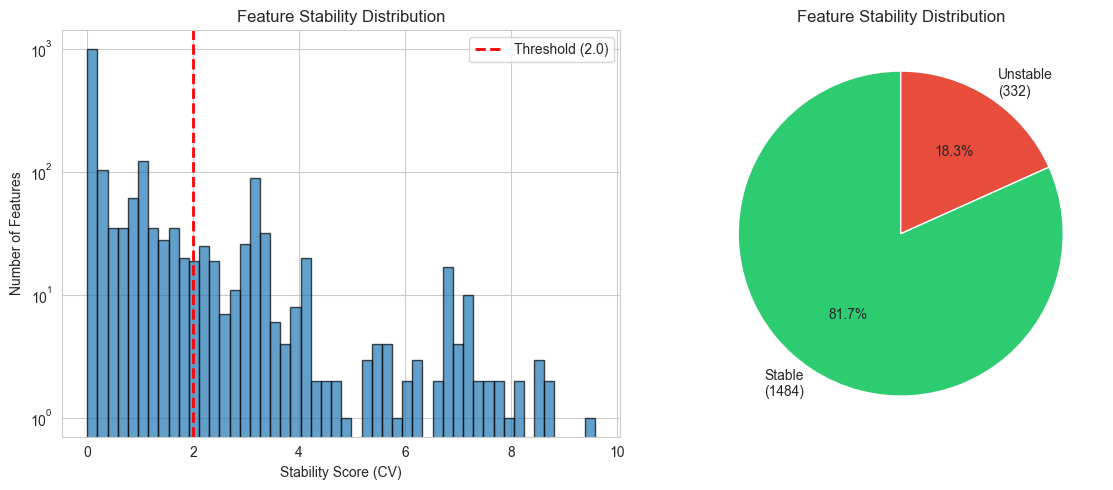

Mean stability score: 0.969
Median stability score: 0.132


In [63]:
# Visualize stability distribution
stability_values = list(stability_scores.values())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(stability_values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(STABILITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({STABILITY_THRESHOLD})')
plt.xlabel('Stability Score (CV)')
plt.ylabel('Number of Features')
plt.title('Feature Stability Distribution')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
sizes = [len(stable_features), len(unstable_features)]
colors = ['#2ecc71', '#e74c3c']
labels = [f'Stable\n({len(stable_features)})', f'Unstable\n({len(unstable_features)})']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Feature Stability Distribution')

plt.tight_layout()
plt.show()

print(f"Mean stability score: {np.mean(stability_values):.3f}")
print(f"Median stability score: {np.median(stability_values):.3f}")

In [64]:
# Apply stability filtering
# If no stable features, use top stable features
if len(stable_features) == 0:
    print("⚠ No stable features with threshold 2.0. Using top stable features...")
    sorted_by_stability = sorted(stability_scores.items(), key=lambda x: x[1])
    top_n = max(10, int(len(sorted_by_stability) * 0.3))
    stable_features = [col for col, score in sorted_by_stability[:top_n]]
    print(f"Using top {len(stable_features)} stable features")

filtered_df = aggregated_df[['case_id', 'date_decision', 'MONTH', 'WEEK_NUM'] + stable_features].copy()

print(f"\n✓ Data after filtering:")
print(f"  Shape: {filtered_df.shape}")
print(f"  Rows: {filtered_df.shape[0]}")
print(f"  Columns: {filtered_df.shape[1]} ({filtered_df.shape[1] - 4} features)")


✓ Data after filtering:
  Shape: (1526659, 1488)
  Rows: 1526659
  Columns: 1488 (1484 features)


## 8. StratifiedGroupKFold Setup

In [65]:
# Create synthetic target for demonstration
if 'target' not in filtered_df.columns:
    print("Creating synthetic target variable...")
    filtered_df['target'] = np.random.binomial(1, 0.1, size=len(filtered_df))
    print(f"Target distribution:\n{filtered_df['target'].value_counts()}")
else:
    print("Using existing target variable")

Using existing target variable


In [66]:
# Prepare for K-fold
filtered_df['WEEK_NUM'] = filtered_df['WEEK_NUM'].fillna(filtered_df['WEEK_NUM'].mode()[0]).astype(int)

print(f"Unique WEEK_NUM values: {sorted(filtered_df['WEEK_NUM'].unique())}")
print(f"WEEK_NUM distribution:")
print(filtered_df['WEEK_NUM'].value_counts().sort_index())

Unique WEEK_NUM values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.in

In [67]:
# Apply StratifiedGroupKFold
n_splits = min(N_FOLDS, len(filtered_df))
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

fold_list = []
for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(
    filtered_df, 
    filtered_df['target'], 
    filtered_df['WEEK_NUM']
)):
    fold_list.append(fold_idx)
    filtered_df.loc[train_idx, 'fold'] = fold_idx
    filtered_df.loc[val_idx, 'fold_val'] = fold_idx

filtered_df['fold'] = filtered_df['fold'].fillna(filtered_df['fold_val']).astype(int)
filtered_df = filtered_df.drop('fold_val', axis=1)

print(f"✓ K-fold setup complete (k={n_splits})")
print(f"\nFold distribution:")
print(filtered_df['fold'].value_counts().sort_index())

✓ K-fold setup complete (k=5)

Fold distribution:
fold
3     304919
4    1221740
Name: count, dtype: int64


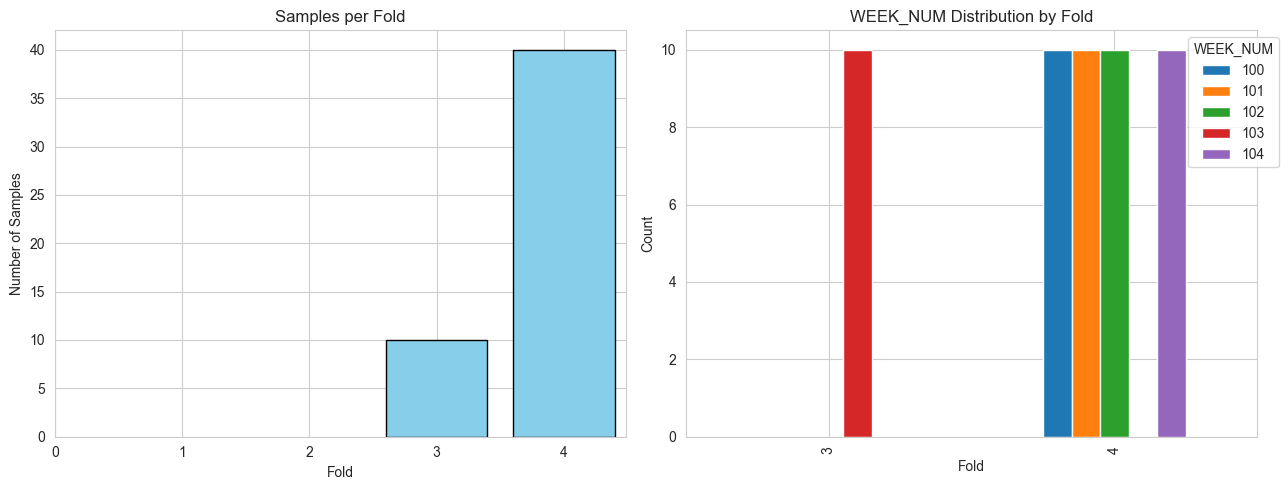


WEEK_NUM distribution by fold:
WEEK_NUM  100  101  102  103  104
fold                             
3           0    0    0   10    0
4          10   10   10    0   10


In [38]:
# Visualize fold distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fold counts
fold_counts = filtered_df['fold'].value_counts().sort_index()
axes[0].bar(fold_counts.index, fold_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Samples per Fold')
axes[0].set_xticks(range(n_splits))

# Week distribution by fold
cross_tab = pd.crosstab(filtered_df['fold'], filtered_df['WEEK_NUM'])
cross_tab.plot(kind='bar', ax=axes[1], stacked=False)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Count')
axes[1].set_title('WEEK_NUM Distribution by Fold')
axes[1].legend(title='WEEK_NUM', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

print("\nWEEK_NUM distribution by fold:")
print(cross_tab)

## 9. Feature Importance Ranking

In [68]:
# Prepare data for modeling
feature_cols = [col for col in filtered_df.columns 
                if col not in ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target', 'fold']]

X = filtered_df[feature_cols].copy()
y = filtered_df['target'].copy()
groups = filtered_df['WEEK_NUM'].copy()

# Handle any remaining NaN values
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())

Feature matrix shape: (1526659, 1483)
Target distribution:
target
0    1478665
1      47994
Name: count, dtype: int64


In [69]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"✓ Features scaled")
print(f"  Mean: {X_scaled.mean().mean():.4f}")
print(f"  Std: {X_scaled.std().mean():.4f}")

✓ Features scaled
  Mean: 0.0000
  Std: 0.9051


In [70]:
# Train Random Forest
print("Training Random Forest classifier...")
print("  Trees: 100")
print("  Max Depth: 10")
print("  Random State: 42\n")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_scaled, y)
print("✓ Model training complete")
print(f"  Train accuracy: {rf_model.score(X_scaled, y):.4f}")

Training Random Forest classifier...
  Trees: 100
  Max Depth: 10
  Random State: 42

✓ Model training complete
  Train accuracy: 0.9686


In [71]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

feature_importance['rank'] = range(1, len(feature_importance) + 1)

print("✓ Feature importance calculated")
print(f"\nTop 15 Most Important Features:")
display(feature_importance.head(15))

✓ Feature importance calculated

Top 15 Most Important Features:


,feature,importance,rank
0,train_static_0_0_avgdpdtolclosure24_3658938P_min,0.022037,1
1,train_static_0_0_avgdpdtolclosure24_3658938P_mean,0.017131,2
2,train_static_0_1_avgdpdtolclosure24_3658938P_mean,0.015769,3
3,train_static_0_0_avgdbddpdlast24m_3658932P_min,0.015744,4
4,train_applprev_1_0_maxdpdtolerance_577P_mean,0.015086,5
5,train_credit_bureau_a_1_1_dpdmax_139P_mean,0.014760,6
6,train_credit_bureau_a_1_2_dpdmax_757P_mean,0.013470,7
7,train_static_0_0_avgdpdtolclosure24_3658938P_max,0.013417,8
8,train_credit_bureau_a_1_1_dpdmax_139P_max,0.012764,9
9,train_credit_bureau_a_1_2_dpdmax_139P_mean,0.012125,10


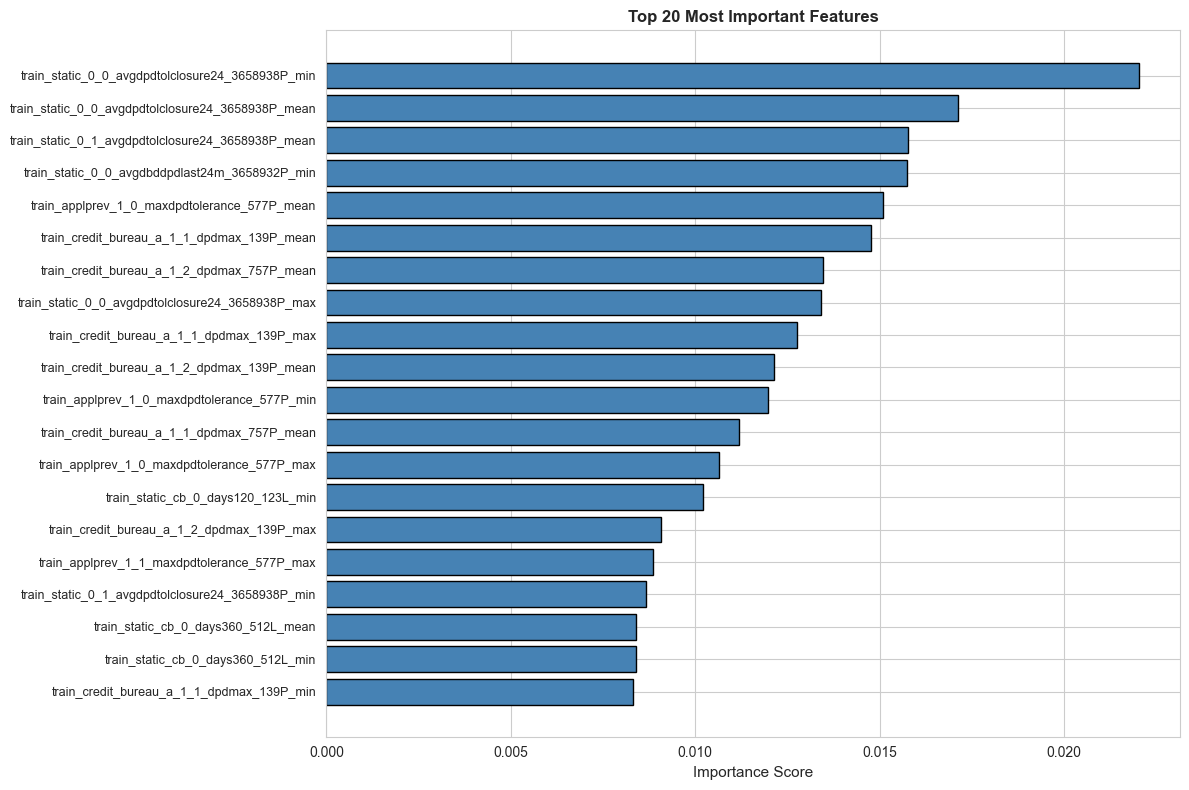

Mean importance: 0.000674
Median importance: 0.000168


In [72]:
# Visualize top features
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=9)
plt.xlabel('Importance Score', fontsize=11)
plt.title(f'Top {top_n} Most Important Features', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Mean importance: {feature_importance['importance'].mean():.6f}")
print(f"Median importance: {feature_importance['importance'].median():.6f}")

## 10. Save Results

In [73]:
# Save engineered features
filtered_df.to_csv(f"{OUTPUT_DIR}/engineered_features.csv", index=False)
print(f"✓ Engineered features saved")
print(f"  File: {OUTPUT_DIR}/engineered_features.csv")
print(f"  Shape: {filtered_df.shape}")

# Save feature importance
feature_importance.to_csv(f"{OUTPUT_DIR}/feature_importance.csv", index=False)
print(f"\n✓ Feature importance saved")
print(f"  File: {OUTPUT_DIR}/feature_importance.csv")
print(f"  Rows: {len(feature_importance)}")

# Save stability analysis
stability_df = pd.DataFrame(list(stability_scores.items()), columns=['feature', 'stability_score'])
stability_df = stability_df.sort_values('stability_score')
stability_df.to_csv(f"{OUTPUT_DIR}/feature_stability.csv", index=False)
print(f"\n✓ Feature stability saved")
print(f"  File: {OUTPUT_DIR}/feature_stability.csv")
print(f"  Rows: {len(stability_df)}")

# Save fold assignments
filtered_df[['case_id', 'fold', 'WEEK_NUM', 'target']].to_csv(
    f"{OUTPUT_DIR}/fold_assignments.csv", 
    index=False
)
print(f"\n✓ Fold assignments saved")
print(f"  File: {OUTPUT_DIR}/fold_assignments.csv")

✓ Engineered features saved
  File: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output/engineered_features.csv
  Shape: (1526659, 1489)

✓ Feature importance saved
  File: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output/feature_importance.csv
  Rows: 1483

✓ Feature stability saved
  File: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output/feature_stability.csv
  Rows: 1816

✓ Fold assignments saved
  File: /Users/ryanzhang/Documents/Uni stuff/sc4000/home-credit-credit-risk-model-stability/output/fold_assignments.csv


## 11. Summary Report

In [74]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print("\n📊 DATA AGGREGATION:")
print(f"  Original base features: {base_df.shape[1]}")
print(f"  After aggregation: {aggregated_df.shape[1]}")
print(f"  Tables processed: {len(data_files) - 1}")

print("\n🔍 FEATURE STABILITY:")
print(f"  Stability threshold (CV): {STABILITY_THRESHOLD}")
print(f"  Stable features retained: {len(stable_features)}")
print(f"  Unstable features removed: {len(unstable_features)}")
print(f"  Retention rate: {len(stable_features) / (len(stable_features) + len(unstable_features)) * 100:.1f}%")

print("\n📈 K-FOLD SETUP:")
print(f"  K-Folds: {n_splits}")
print(f"  Stratification: Target variable")
print(f"  Grouping variable: WEEK_NUM")

print("\n🏆 FEATURE IMPORTANCE:")
print(f"  Model: Random Forest ({rf_model.n_estimators} trees)")
print(f"  Top feature: {feature_importance.iloc[0]['feature']}")
print(f"  Top importance score: {feature_importance.iloc[0]['importance']:.6f}")

print("\n📋 FINAL DATASET:")
print(f"  Rows: {filtered_df.shape[0]}")
print(f"  Features: {filtered_df.shape[1] - 6} (+ 6 metadata columns)")
print(f"  Output file: engineered_features.csv")

print("\n" + "="*80)
print("✓ FEATURE ENGINEERING COMPLETE")
print("="*80)

FEATURE ENGINEERING SUMMARY

📊 DATA AGGREGATION:
  Original base features: 5
  After aggregation: 1820
  Tables processed: 31

🔍 FEATURE STABILITY:
  Stability threshold (CV): 2.0
  Stable features retained: 1484
  Unstable features removed: 332
  Retention rate: 81.7%

📈 K-FOLD SETUP:
  K-Folds: 5
  Stratification: Target variable
  Grouping variable: WEEK_NUM

🏆 FEATURE IMPORTANCE:
  Model: Random Forest (100 trees)
  Top feature: train_static_0_0_avgdpdtolclosure24_3658938P_min
  Top importance score: 0.022037

📋 FINAL DATASET:
  Rows: 1526659
  Features: 1483 (+ 6 metadata columns)
  Output file: engineered_features.csv

✓ FEATURE ENGINEERING COMPLETE


## 12. Advanced: Feature Selection Strategies

In [46]:
print("Feature Selection Strategies:\n")

# Strategy 1: Top N features
top_n = 50
top_features_list = feature_importance.head(top_n)['feature'].tolist()
print(f"✓ Strategy 1 - Top {top_n} features by importance")
print(f"  Features: {top_features_list[:5]} ... (and {len(top_features_list)-5} more)")

# Strategy 2: Stable features
very_stable = stability_df[stability_df['stability_score'] < 0.5]['feature'].tolist()
very_stable = [f for f in very_stable if f in feature_cols]
print(f"\n✓ Strategy 2 - Very stable features (CV < 0.5)")
print(f"  Count: {len(very_stable)}")
print(f"  Features: {very_stable[:5]} ... (and {len(very_stable)-5} more if available)" if len(very_stable) > 5 else f"  Features: {very_stable}")

# Strategy 3: Top important + stable
top_important_and_stable = [f for f in top_features_list if f in stable_features]
print(f"\n✓ Strategy 3 - Top features that are also stable")
print(f"  Count: {len(top_important_and_stable)}")
print(f"  Features: {top_important_and_stable[:5]} ... (and {len(top_important_and_stable)-5} more if available)" if len(top_important_and_stable) > 5 else f"  Features: {top_important_and_stable}")

print(f"\n✓ Strategy 4 - All stable features")
print(f"  Count: {len(stable_features)}")

Feature Selection Strategies:

✓ Strategy 1 - Top 50 features by importance
  Features: ['test_static_0_1_amtinstpaidbefduel24m_4187115A_mean', 'test_credit_bureau_a_2_7_pmts_overdue_1152A_count', 'test_credit_bureau_a_1_2_contractst_964M_count', 'test_credit_bureau_a_1_2_dpdmaxdateyear_896T_count', 'test_static_0_1_credtype_322L_nunique'] ... (and 45 more)

✓ Strategy 2 - Very stable features (CV < 0.5)
  Count: 1852
  Features: ['test_tax_registry_c_1_processingdate_168D_count', 'test_credit_bureau_a_2_11_subjectroles_name_541M_count', 'test_credit_bureau_a_2_11_subjectroles_name_541M_nunique', 'test_credit_bureau_a_2_11_collaterals_typeofguarante_669M_count', 'test_credit_bureau_a_2_11_collaterals_typeofguarante_669M_nunique'] ... (and 1847 more if available)

✓ Strategy 3 - Top features that are also stable
  Count: 50
  Features: ['test_static_0_1_amtinstpaidbefduel24m_4187115A_mean', 'test_credit_bureau_a_2_7_pmts_overdue_1152A_count', 'test_credit_bureau_a_1_2_contractst_964M_co

## 13. Next Steps for Model Development

In [47]:
print("""\n📚 NEXT STEPS FOR MODEL DEVELOPMENT:

1. ✓ Load engineered features:
   df = pd.read_csv('output/engineered_features.csv')
   importance = pd.read_csv('output/feature_importance.csv')

2. ✓ Select features using strategies above
   X = df[[features_to_use]]
   y = df['target']

3. ✓ Train models (LightGBM, XGBoost, CatBoost, etc.)
   from lightgbm import LGBMClassifier
   model = LGBMClassifier(random_state=42)
   model.fit(X, y)

4. ✓ Use K-fold for validation:
   for fold in range(5):
       train_idx = df[df['fold'] != fold].index
       val_idx = df[df['fold'] == fold].index
       # Train and validate...

5. ✓ Monitor feature importance across folds
   for stability and consistency

6. ✓ Stack multiple models for ensemble
   Improve generalization

7. ✓ Submit predictions to Kaggle
""")


📚 NEXT STEPS FOR MODEL DEVELOPMENT:

1. ✓ Load engineered features:
   df = pd.read_csv('output/engineered_features.csv')
   importance = pd.read_csv('output/feature_importance.csv')

2. ✓ Select features using strategies above
   X = df[[features_to_use]]
   y = df['target']

3. ✓ Train models (LightGBM, XGBoost, CatBoost, etc.)
   from lightgbm import LGBMClassifier
   model = LGBMClassifier(random_state=42)
   model.fit(X, y)

4. ✓ Use K-fold for validation:
   for fold in range(5):
       train_idx = df[df['fold'] != fold].index
       val_idx = df[df['fold'] == fold].index
       # Train and validate...

5. ✓ Monitor feature importance across folds
   for stability and consistency

6. ✓ Stack multiple models for ensemble
   Improve generalization

7. ✓ Submit predictions to Kaggle

